In [4]:
import pandas as pd

def load_and_merge_transaction_identity(transactions_csv, identity_csv):
    """
    Load transaction and identity data, merge on TransactionID.
    Fill missing values for key fields.
    """
    # Load transaction data (including 'isFraud')
    transactions = pd.read_csv(transactions_csv, usecols=['TransactionID', 'card1', 'isFraud'])

    # Load identity data with device info
    identity = pd.read_csv(identity_csv, usecols=['TransactionID', 'DeviceType', 'DeviceInfo'])

    # Merge on TransactionID
    df = transactions.merge(identity, on='TransactionID', how='left')

    # Fill missing values with 'unknown'
    df.fillna('unknown', inplace=True)

    # Convert key columns to string
    df['card1'] = df['card1'].astype(str)
    df['DeviceType'] = df['DeviceType'].astype(str)
    df['DeviceInfo'] = df['DeviceInfo'].astype(str)

    return df


In [6]:

df = load_and_merge_transaction_identity(
    '../data/train_transaction.csv',
    '../data/train_identity.csv'
)

print(df.head())
print(df['isFraud'].value_counts())


   TransactionID  isFraud  card1 DeviceType                     DeviceInfo
0        2987000        0  13926    unknown                        unknown
1        2987001        0   2755    unknown                        unknown
2        2987002        0   4663    unknown                        unknown
3        2987003        0  18132    unknown                        unknown
4        2987004        0   4497     mobile  SAMSUNG SM-G892A Build/NRD90M
isFraud
0    569877
1     20663
Name: count, dtype: int64


In [7]:
import networkx as nx

def build_transaction_entity_graph(df):
    """
    Builds a bipartite graph:
    - Nodes: TransactionIDs and entity nodes (card1, DeviceType, DeviceInfo)
    - Edges: Between transactions and their entities
    """
    G = nx.Graph()

    for _, row in df.iterrows():
        txn_id = f"txn_{int(row['TransactionID'])}"
        G.add_node(txn_id, node_type='transaction', isFraud=row['isFraud'])

        # Link to card
        card_node = f"card_{row['card1']}"
        G.add_node(card_node, node_type='card')
        G.add_edge(txn_id, card_node)

        # Link to DeviceType
        if row['DeviceType'] != 'unknown':
            device_node = f"device_{row['DeviceType']}"
            G.add_node(device_node, node_type='device_type')
            G.add_edge(txn_id, device_node)

        # Link to DeviceInfo
        if row['DeviceInfo'] != 'unknown':
            devinfo_node = f"devinfo_{row['DeviceInfo']}"
            G.add_node(devinfo_node, node_type='device_info')
            G.add_edge(txn_id, devinfo_node)

    return G


In [8]:
# Build graph
G = build_transaction_entity_graph(df)

print(f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

# Optional: Check a random fraudulent transaction and its neighbors
fraudulent_nodes = [n for n, attr in G.nodes(data=True) if attr.get('isFraud') == 1]
print(f"Found {len(fraudulent_nodes)} fraudulent transactions in the graph.")

if fraudulent_nodes:
    example_fraud = fraudulent_nodes[0]
    print(f"Example fraudulent transaction: {example_fraud}")
    print(f"Neighbors: {list(G.neighbors(example_fraud))}")

Graph has 605881 nodes and 850016 edges.
Found 20663 fraudulent transactions in the graph.
Example fraudulent transaction: txn_2987203
Neighbors: ['card_18268']


In [9]:
import networkx as nx
import matplotlib.pyplot as plt

def visualize_transaction_neighborhood(G, transaction_node, depth=1):
    """
    Visualize the neighborhood of a given transaction node up to a certain depth.
    """
    # Get nodes within `depth` steps from the transaction
    ego_net = nx.ego_graph(G, transaction_node, radius=depth)

    pos = nx.spring_layout(ego_net, seed=42)

    # Node coloring based on type
    node_colors = []
    for node, attr in ego_net.nodes(data=True):
        if attr.get('node_type') == 'transaction':
            if attr.get('isFraud') == 1:
                node_colors.append('red')
            else:
                node_colors.append('lightblue')
        else:
            node_colors.append('lightgreen')

    plt.figure(figsize=(10, 8))
    nx.draw(ego_net, pos, with_labels=True, node_color=node_colors, node_size=500, font_size=8, edge_color='gray')
    plt.title(f"Neighborhood of Transaction {transaction_node} (Depth {depth})")
    plt.show()


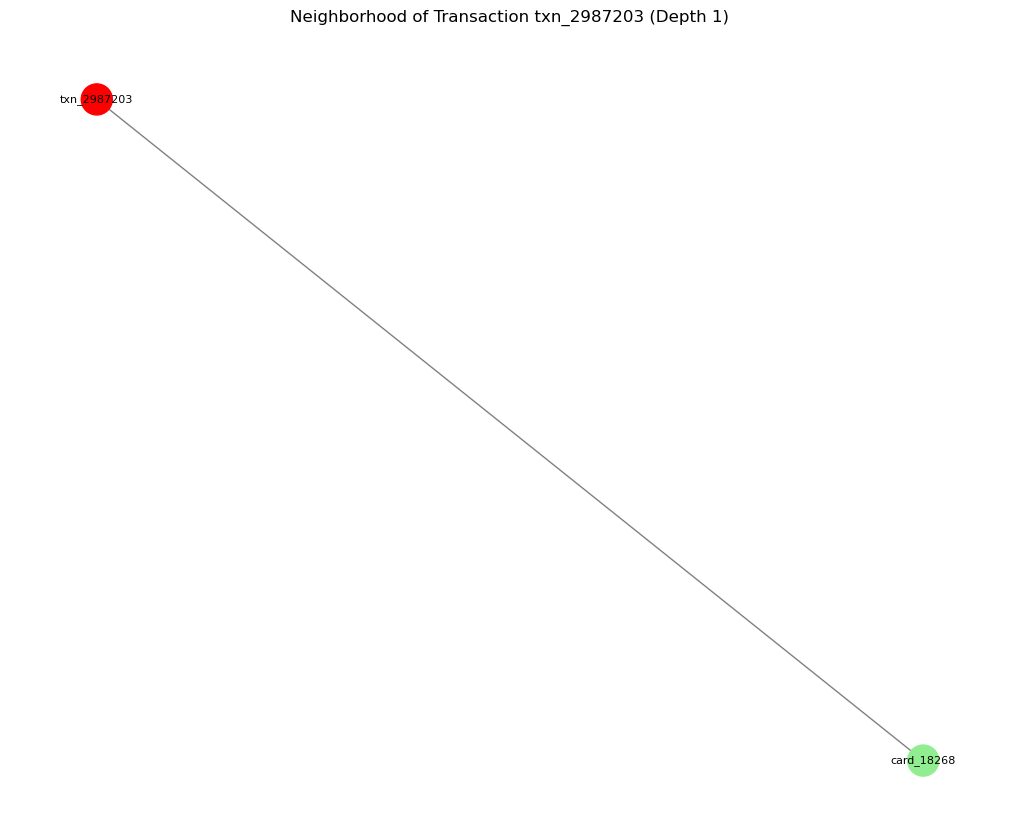

In [12]:
# Visualize first fraudulent transaction's neighborhood
if fraudulent_nodes:
    visualize_transaction_neighborhood(G, fraudulent_nodes[0], depth=1)

In [13]:
import networkx as nx
import matplotlib.pyplot as plt

def visualize_transaction_only_neighborhood(G, transaction_node, depth=2):
    """
    Visualize transaction nodes connected within a certain depth from a given transaction.
    Only displays transaction nodes.
    """
    # Get ego network within depth
    ego_net = nx.ego_graph(G, transaction_node, radius=depth)

    # Filter for transaction nodes only
    txn_nodes = [n for n, attr in ego_net.nodes(data=True) if attr.get('node_type') == 'transaction']
    txn_subgraph = G.subgraph(txn_nodes)

    if len(txn_subgraph) == 0:
        print("No transaction nodes found within this depth.")
        return

    # Layout
    pos = nx.spring_layout(txn_subgraph, seed=42)

    # Node coloring based on fraud status
    node_colors = []
    for node, attr in txn_subgraph.nodes(data=True):
        if attr.get('isFraud') == 1:
            node_colors.append('red')
        else:
            node_colors.append('lightblue')

    plt.figure(figsize=(10, 8))
    nx.draw(txn_subgraph, pos, with_labels=True, node_color=node_colors,
            node_size=500, font_size=8, edge_color='gray')
    plt.title(f"Filtered Neighborhood of Transaction {transaction_node} (Depth {depth}) - Transactions Only")
    plt.show()


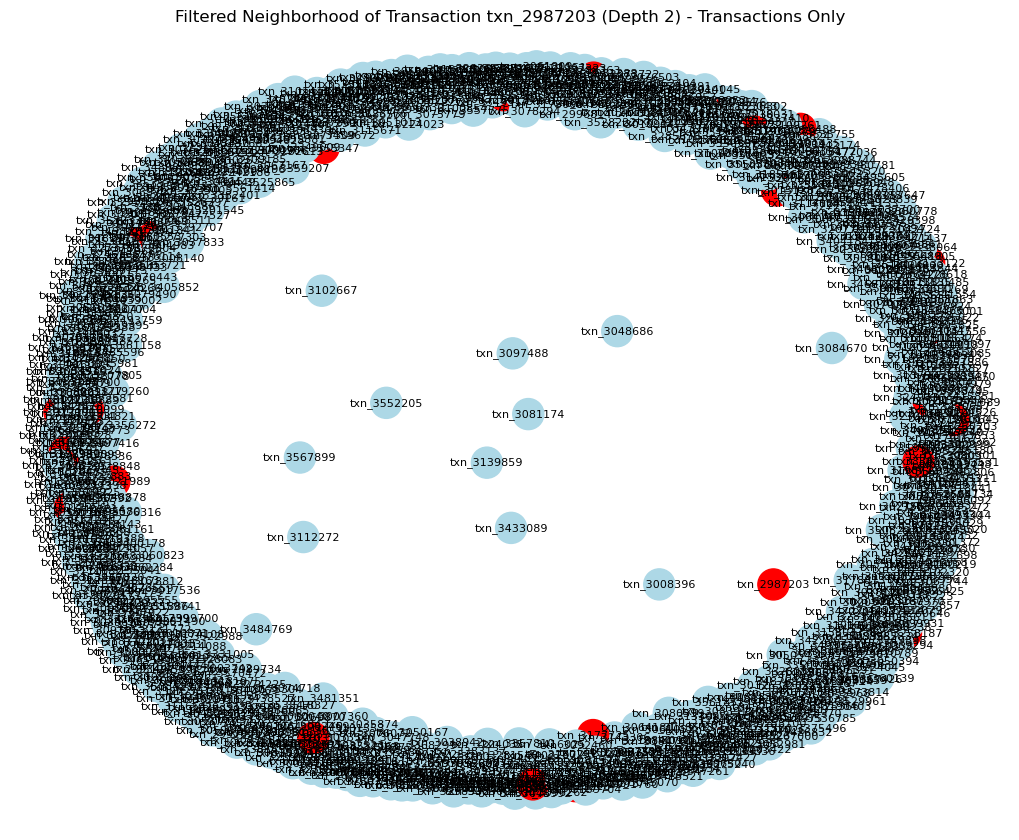

In [14]:
# Visualize with only transactions shown
if fraudulent_nodes:
    visualize_transaction_only_neighborhood(G, fraudulent_nodes[0], depth=2)

In [15]:
import networkx as nx

def bfs_find_neighboring_transactions(G, start_node, max_depth=2):
    """
    Perform BFS starting from start_node, collecting neighboring transaction nodes up to max_depth.
    Only transaction nodes are collected.
    """
    visited = set()
    queue = [(start_node, 0)]  # (node, current_depth)
    result = []

    while queue:
        current_node, depth = queue.pop(0)
        if current_node in visited:
            continue
        visited.add(current_node)

        # Collect if it's a transaction node (but skip the starting node itself)
        if G.nodes[current_node].get('node_type') == 'transaction' and current_node != start_node:
            result.append({
                'transaction_id': current_node,
                'isFraud': G.nodes[current_node].get('isFraud'),
                'depth': depth
            })

        if depth < max_depth:
            neighbors = G.neighbors(current_node)
            for neighbor in neighbors:
                if neighbor not in visited:
                    queue.append((neighbor, depth + 1))

    return result


In [16]:
# Explore neighbors of the first fraudulent transaction
if fraudulent_nodes:
    neighbors = bfs_find_neighboring_transactions(G, fraudulent_nodes[0], max_depth=2)

    print(f"Found {len(neighbors)} neighboring transactions within 2 hops.")
    for neighbor in neighbors[:10]:  # Show first 10
        print(neighbor)

Found 1129 neighboring transactions within 2 hops.
{'transaction_id': 'txn_2989213', 'isFraud': 0, 'depth': 2}
{'transaction_id': 'txn_2989310', 'isFraud': 0, 'depth': 2}
{'transaction_id': 'txn_2989316', 'isFraud': 0, 'depth': 2}
{'transaction_id': 'txn_2989599', 'isFraud': 0, 'depth': 2}
{'transaction_id': 'txn_2989734', 'isFraud': 0, 'depth': 2}
{'transaction_id': 'txn_2990418', 'isFraud': 0, 'depth': 2}
{'transaction_id': 'txn_2991760', 'isFraud': 0, 'depth': 2}
{'transaction_id': 'txn_2993497', 'isFraud': 0, 'depth': 2}
{'transaction_id': 'txn_2995063', 'isFraud': 0, 'depth': 2}
{'transaction_id': 'txn_2995122', 'isFraud': 0, 'depth': 2}


In [18]:

def analyze_fraud_clustering(G, transaction_nodes, max_depth=2):
    """
    For each transaction node, count the number of fraudulent neighboring transactions.
    Returns a list of dicts with transaction_id, isFraud, fraud_neighbor_count.
    """
    clustering_data = []

    for txn_node in transaction_nodes:
        neighbors = bfs_find_neighboring_transactions(G, txn_node, max_depth=max_depth)
        fraud_neighbor_count = sum(1 for n in neighbors if n['isFraud'] == 1)

        clustering_data.append({
            'transaction_id': txn_node,
            'isFraud': G.nodes[txn_node].get('isFraud'),
            'fraud_neighbor_count': fraud_neighbor_count
        })

    return clustering_data


In [30]:
# Get all transaction nodes (you may want to sample for performance)
transaction_nodes = [n for n, attr in G.nodes(data=True) if attr.get('node_type') == 'transaction']

# Analyze clustering for a sample (e.g., 5000 transactions)
import random
sampled_nodes = random.sample(transaction_nodes, 50)

clustering_results = analyze_fraud_clustering(G, sampled_nodes, max_depth=3)

# Convert to DataFrame for analysis
import pandas as pd
df_clustering = pd.DataFrame(clustering_results)

print(df_clustering.head())

  transaction_id  isFraud  fraud_neighbor_count
0    txn_3373787        0                    22
1    txn_3240767        0                  5689
2    txn_3135804        0                  5859
3    txn_3409156        0                   112
4    txn_3550221        0                  5657


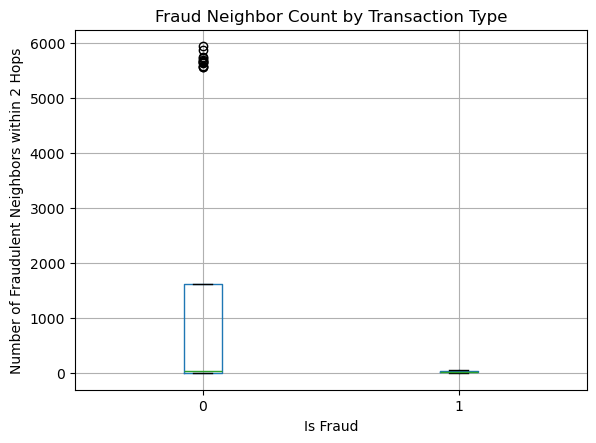

In [31]:
import matplotlib.pyplot as plt

# Boxplot comparing fraud_neighbor_count for fraud vs non-fraud transactions
df_clustering.boxplot(column='fraud_neighbor_count', by='isFraud')
plt.title('Fraud Neighbor Count by Transaction Type')
plt.suptitle('')
plt.xlabel('Is Fraud')
plt.ylabel('Number of Fraudulent Neighbors within 2 Hops')
plt.show()


In [32]:
from scipy.stats import ttest_ind

frauds = df_clustering[df_clustering['isFraud'] == 1]['fraud_neighbor_count']
legit = df_clustering[df_clustering['isFraud'] == 0]['fraud_neighbor_count']

t_stat, p_value = ttest_ind(frauds, legit, equal_var=False)
print(f"T-test result: t-statistic = {t_stat:.2f}, p-value = {p_value:.4f}")


T-test result: t-statistic = -3.99, p-value = 0.0002


At shallow depths (1–2): Fraud neighbors might not show a strong difference — possibly due to noise from shared cards/devices.

At depth 3:
You’re capturing extended fraud rings — maybe via multi-step relationships — where fraud transactions are indirectly connected through shared entities.

In [33]:
fraud_degrees = [G.degree(n) for n in transaction_nodes if G.nodes[n].get('isFraud') == 1]
legit_degrees = [G.degree(n) for n in transaction_nodes if G.nodes[n].get('isFraud') == 0]

# t-test on degrees
from scipy.stats import ttest_ind
t_stat, p_value = ttest_ind(fraud_degrees, legit_degrees, equal_var=False)
print(f"Degree T-test: t = {t_stat:.2f}, p = {p_value:.4f}")


Degree T-test: t = 81.83, p = 0.0000


Fraudulent transactions have, on average, a different number of connections (degree) than legitimate transactions.

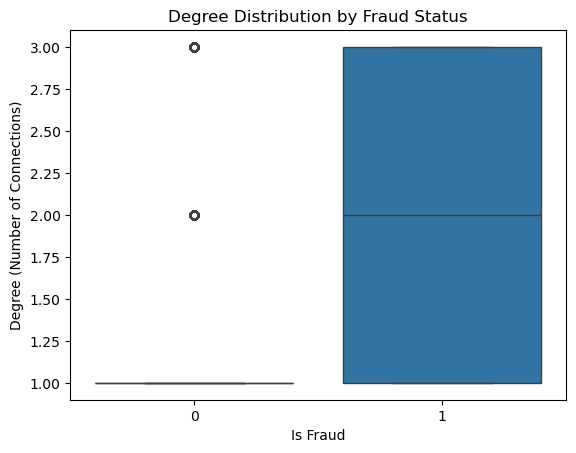

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x='isFraud', y='degree', data=pd.DataFrame({
    'degree': fraud_degrees + legit_degrees,
    'isFraud': [1]*len(fraud_degrees) + [0]*len(legit_degrees)
}))

plt.title('Degree Distribution by Fraud Status')
plt.xlabel('Is Fraud')
plt.ylabel('Degree (Number of Connections)')
plt.show()


# Loading Elliptic Bitcoin Dataset (Kaggle) dataset

 Contains actual Bitcoin transactions linked by edges.

Graph-based structure is already part of the dataset.

Comes with node classifications: illicit, licit, or unknown.

Ideal for applying BFS, clustering, network analysis

In [43]:
import pandas as pd
import networkx as nx

def build_elliptic_transaction_graph(classes_csv, edges_csv):
    import pandas as pd
    import networkx as nx

    classes_df = pd.read_csv(classes_csv, names=['txId', 'class'])

    # Clean class labels — map unknown to 0, convert 1 & 2 to integers
    def clean_class(x):
        if x == '1':
            return 1
        elif x == '2':
            return 2
        else:
            return 0  # Unknown or unlabeled

    classes_df['class'] = classes_df['class'].apply(clean_class)
    classes_dict = pd.Series(classes_df['class'].values, index=classes_df['txId']).to_dict()

    edges_df = pd.read_csv(edges_csv, names=['txId1', 'txId2'])

    G = nx.DiGraph()

    for tx_id, cls in classes_dict.items():
        G.add_node(tx_id, class_label=cls)

    for _, row in edges_df.iterrows():
        G.add_edge(row['txId1'], row['txId2'])

    return G



In [44]:

G = build_elliptic_transaction_graph(
    '../data/elliptic_bitcoin_dataset/elliptic_txs_classes.csv',
    '../data/elliptic_bitcoin_dataset/elliptic_txs_edgelist.csv'
)

print(f"Graph loaded with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

# Sample check on illicit nodes
illicit_nodes = [n for n, attr in G.nodes(data=True) if attr.get('class_label') == 1]
print(f"Found {len(illicit_nodes)} illicit (fraudulent) transactions.")


Graph loaded with 203772 nodes and 234356 edges.
Found 4545 illicit (fraudulent) transactions.


## Ego Network of an Illicit Transaction

In [45]:
import networkx as nx
import matplotlib.pyplot as plt

def visualize_illicit_ego_network(G, illicit_node, depth=1):
    """
    Visualize the ego network of an illicit transaction.
    Shows its neighbors up to `depth` steps.
    """
    ego_net = nx.ego_graph(G, illicit_node, radius=depth)
    pos = nx.spring_layout(ego_net, seed=42)

    node_colors = []
    for node, attr in ego_net.nodes(data=True):
        if attr.get('class_label') == 1:
            node_colors.append('red')  # Illicit
        elif attr.get('class_label') == 2:
            node_colors.append('lightblue')  # Licit
        else:
            node_colors.append('gray')  # Unknown

    plt.figure(figsize=(10, 8))
    nx.draw(ego_net, pos, node_color=node_colors, with_labels=True,
            node_size=500, font_size=8, edge_color='lightgray')
    plt.title(f"Ego Network of Illicit Transaction {illicit_node} (Depth {depth})")
    plt.show()


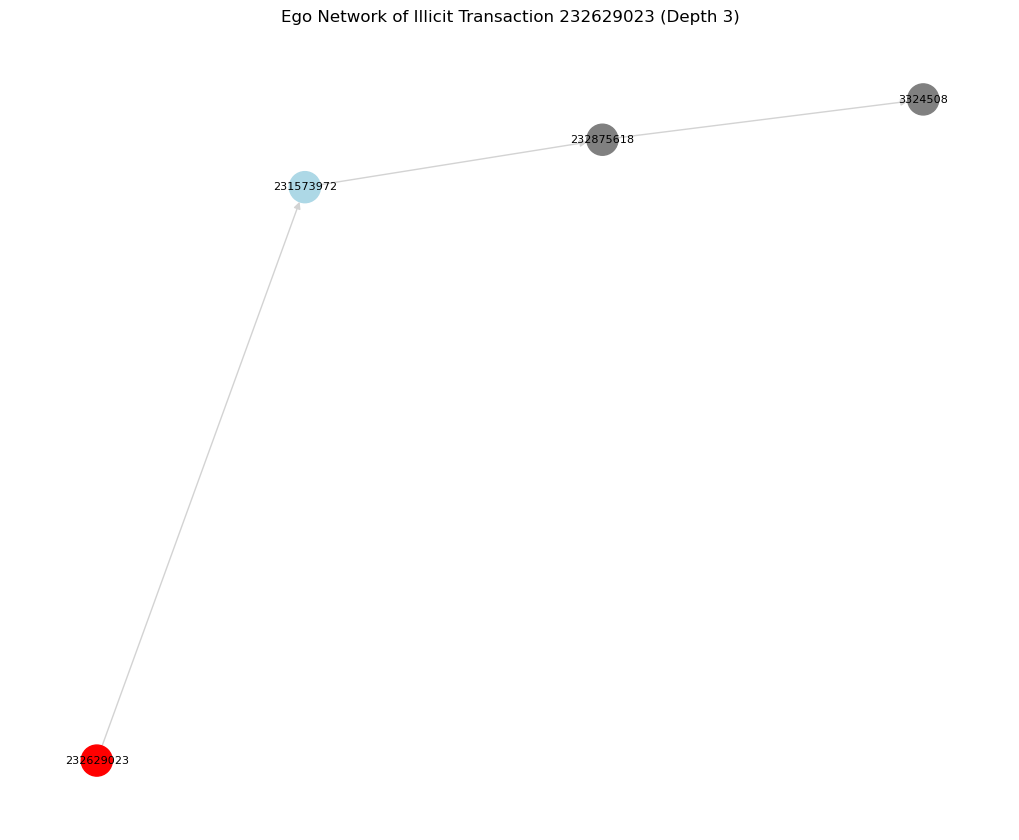

In [48]:
if illicit_nodes:
    visualize_illicit_ego_network(G, illicit_nodes[0], depth=3)


## Degree distributions

In [63]:
import matplotlib.pyplot as plt

def plot_degree_distribution(G):
    illicit_deg = [G.degree(n) for n, attr in G.nodes(data=True) if attr.get('class_label') == 1]
    licit_deg = [G.degree(n) for n, attr in G.nodes(data=True) if attr.get('class_label') == 2]

    plt.figure(figsize=(10, 6))
    plt.hist(illicit_deg, bins=250, alpha=0.7, label='Illicit', color='brown')
    plt.hist(licit_deg, bins=250, alpha=0.7, label='Licit', color='lightblue')
    plt.xlabel('Degree (Number of Connections)')
    plt.ylabel('Frequency')
    plt.xscale('log')
    plt.yscale('log')
    plt.title('Degree Distribution: Illicit vs Licit Transactions')
    plt.legend()
    plt.show()


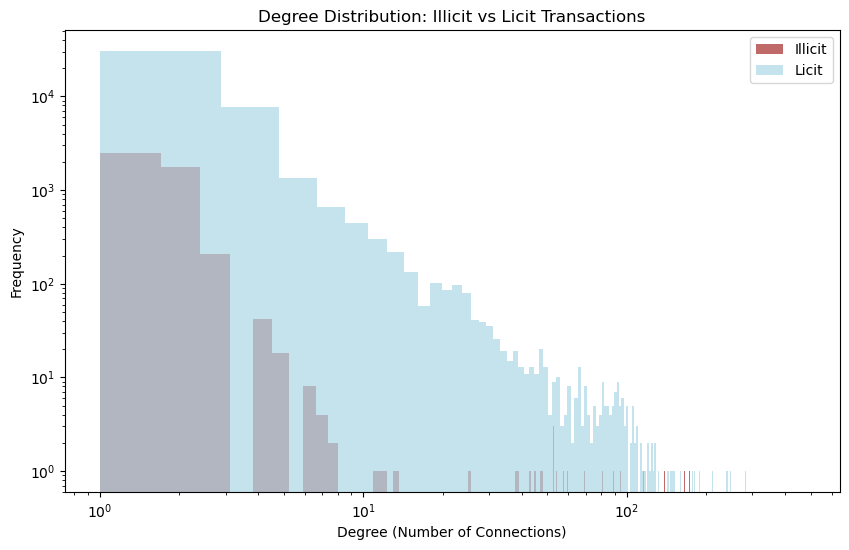

In [64]:
plot_degree_distribution(G)

## Connected Components

In [65]:
import networkx as nx
import matplotlib.pyplot as plt

def plot_component_size_distribution(G):
    components = list(nx.weakly_connected_components(G))
    sizes = [len(comp) for comp in components]

    plt.figure(figsize=(10, 6))
    plt.hist(sizes, bins=50, color='purple', alpha=0.7)
    plt.xlabel('Component Size')
    plt.ylabel('Frequency')
    plt.title('Distribution of Weakly Connected Component Sizes')
    plt.show()


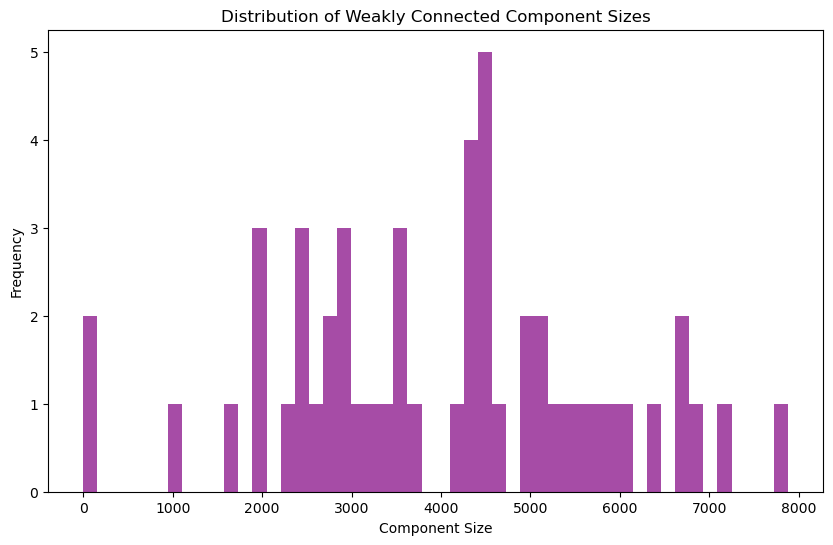

In [66]:
plot_component_size_distribution(G)

## BFS Neighbor Finder

In [67]:
def bfs_find_neighboring_transactions(G, start_node, max_depth=2):
    """
    Perform BFS on Elliptic graph starting from `start_node`.
    Collect neighboring transactions up to `max_depth`.
    Returns a list of dicts with transaction_id, class_label, and depth.
    """
    visited = set()
    queue = [(start_node, 0)]
    results = []

    while queue:
        current_node, depth = queue.pop(0)
        if current_node in visited:
            continue
        visited.add(current_node)

        if current_node != start_node:
            results.append({
                'transaction_id': current_node,
                'class_label': G.nodes[current_node].get('class_label', 0),
                'depth': depth
            })

        if depth < max_depth:
            neighbors = G.neighbors(current_node)
            for neighbor in neighbors:
                if neighbor not in visited:
                    queue.append((neighbor, depth + 1))

    return results


In [80]:
# Pick the first illicit transaction for example
if illicit_nodes:
    neighbors = bfs_find_neighboring_transactions(G, illicit_nodes[0], max_depth=5)

    print(f"Found {len(neighbors)} neighboring transactions within 5 hops.")
    for neighbor in neighbors[:10]:  # Show sample of neighbors
        print(neighbor)

Found 4 neighboring transactions within 5 hops.
{'transaction_id': '231573972', 'class_label': 2, 'depth': 1}
{'transaction_id': '232875618', 'class_label': 0, 'depth': 2}
{'transaction_id': '3324508', 'class_label': 0, 'depth': 3}
{'transaction_id': '230713915', 'class_label': 0, 'depth': 4}


In [81]:
df_neighbors = pd.DataFrame(neighbors)
print(df_neighbors['class_label'].value_counts())

class_label
0    3
2    1
Name: count, dtype: int64


## Connected component analysis

In [93]:
import networkx as nx

def analyze_connected_components(G):
    """
    Analyze weakly connected components.
    For each component, report its size and number of illicit transactions.
    """
    components = list(nx.weakly_connected_components(G))
    component_summaries = []

    for comp in components:
        illicit_count = sum(
            1 for node in comp if G.nodes[node].get('class_label') == 1
        )
        licit_count = sum(
            1 for node in comp if G.nodes[node].get('class_label') == 2
        )
        unknown_count = len(comp) - illicit_count - licit_count

        component_summaries.append({
            'component_size': len(comp),
            'illicit_count': illicit_count,
            'licit_count': licit_count,
            'unknown_count': unknown_count
        })

    return component_summaries


def visualize_component(G, component_nodes):
    subG = G.subgraph(component_nodes)
    pos = nx.spring_layout(subG, seed=42)

    node_colors = []
    for node in subG.nodes():
        label = G.nodes[node].get('class_label')
        if label == 1:
            node_colors.append('red')      # Illicit
        elif label == 2:
            node_colors.append('lightblue')  # Licit
        else:
            node_colors.append('gray')     # Unknown

    plt.figure(figsize=(10, 8))
    nx.draw(subG, pos, node_color=node_colors, with_labels=False, node_size=100, edge_color='lightgray', alpha = 0.6)
    plt.title(f"Component with {len(component_nodes)} nodes")
    plt.show()



In [ ]:
summaries = analyze_connected_components(G)
df_components = pd.DataFrame(summaries)

print(df_components.describe())

# Components with at least 1 illicit transaction, sorted by size
df_with_illicit = df_components[df_components['illicit_count'] > 0]
df_with_illicit = df_with_illicit.sort_values(by='component_size', ascending=False)
# df_with_illicit.head()

       component_size  illicit_count  licit_count  unknown_count
count       51.000000      51.000000    51.000000      51.000000
mean      3995.529412      89.117647   823.901961    3082.509804
std       1760.300956      87.002677   496.682041    1336.372289
min          1.000000       0.000000     0.000000       1.000000
25%       2788.000000      23.500000   464.500000    2056.000000
50%       4275.000000      67.000000   665.000000    3101.000000
75%       5092.000000     117.000000  1101.500000    4148.500000
max       7880.000000     342.000000  2130.000000    5755.000000


,component_size,illicit_count,licit_count,unknown_count
1,7880,17,2130,5733
42,7140,239,1915,4986
5,6803,8,1874,4921
10,6727,18,954,5755
3,6621,11,1268,5342


Frauds are embedded in large, mixed components, not isolated.

Fraud isn't forming small cliques, it coexists with legitimate and unknown transactions in massive transaction flows.

The high unknown count reflects how unlabeled transactions dominate the network, typical for semi-supervised scenarios.

### Top N Nodes of a Large Component

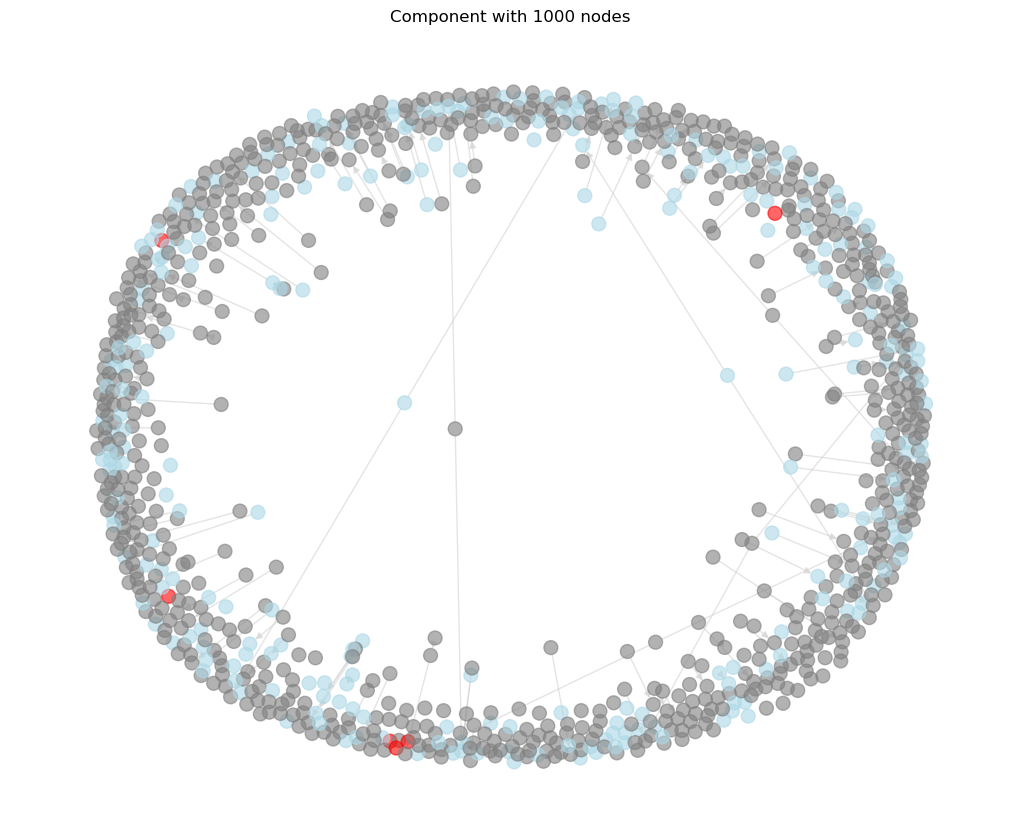

In [94]:
# Find the largest component with illicit transactions
components = list(nx.weakly_connected_components(G))
largest_illicit_comp = max(
    (comp for comp in components if any(G.nodes[n].get('class_label') == 1 for n in comp)),
    key=len
)

sampled_nodes = list(largest_illicit_comp)[:1000]  # First 200 nodes
visualize_component(G, sampled_nodes)

###  Illicit + Direct Neighbors

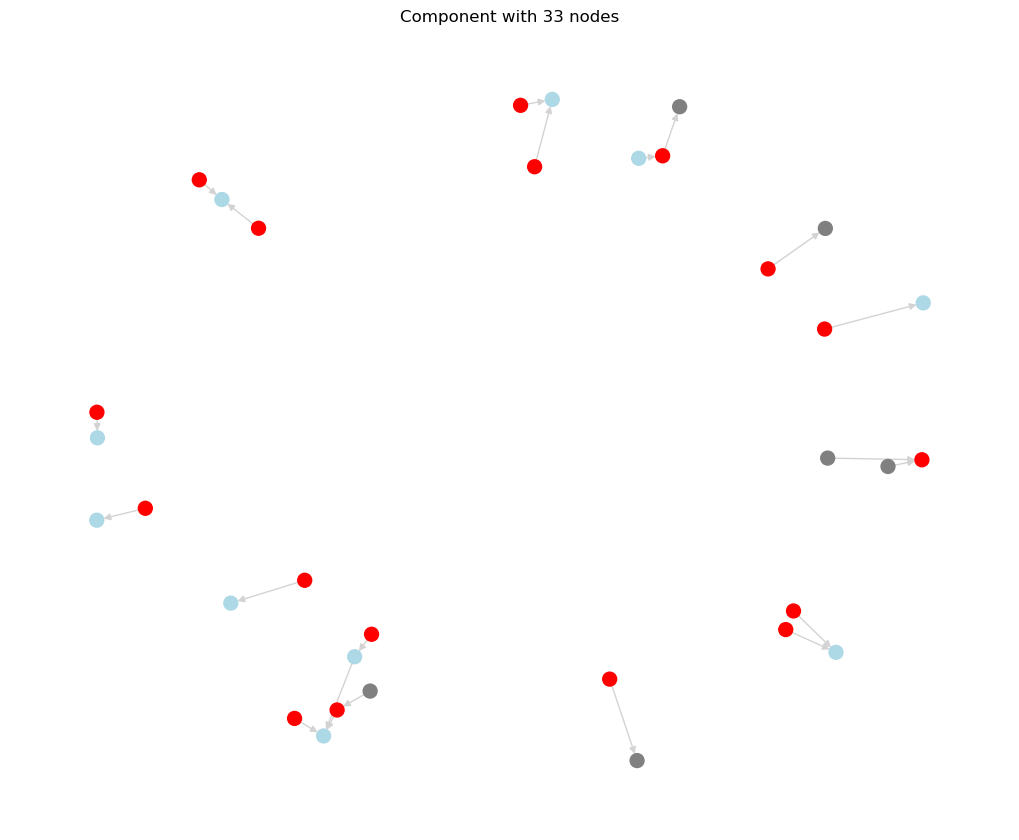

In [89]:
def get_illicit_with_neighbors(G, component_nodes):
    illicit_nodes = [n for n in component_nodes if G.nodes[n].get('class_label') == 1]
    neighbors = set()

    for node in illicit_nodes:
        neighbors.update(G.neighbors(node))
        neighbors.update(G.predecessors(node))

    return set(illicit_nodes).union(neighbors)

illicit_and_neighbors = get_illicit_with_neighbors(G, largest_illicit_comp)
visualize_component(G, list(illicit_and_neighbors)[:300])  # Visualize up to 300 nodes


### Centrality Metrics

Degree Centrality: How many direct connections a node has

Betweenness Centrality:	How often a node lies on shortest paths between others (influence)

Closeness Centrality: How close a node is to all other nodes (spread potential)


In [96]:
def calculate_centrality_metrics(G, sample_size=5000):
    """
    Calculate degree, betweenness, and closeness centrality.
    Returns a DataFrame with node ID, class label, and centrality scores.
    Samples nodes for betweenness and closeness due to computation time.
    """

    nodes_data = []

    # Degree Centrality (fast)
    degree_dict = nx.degree_centrality(G)

    # Sample nodes for betweenness/closeness (to avoid long runtimes)
    sampled_nodes = list(degree_dict.keys())[:sample_size]
    subG = G.subgraph(sampled_nodes)

    betweenness_dict = nx.betweenness_centrality(subG)
    closeness_dict = nx.closeness_centrality(subG)

    for node in sampled_nodes:
        nodes_data.append({
            'transaction_id': node,
            'class_label': G.nodes[node].get('class_label', 0),
            'degree_centrality': degree_dict.get(node, 0),
            'betweenness_centrality': betweenness_dict.get(node, 0),
            'closeness_centrality': closeness_dict.get(node, 0)
        })

    return pd.DataFrame(nodes_data)


In [106]:

df_centrality = calculate_centrality_metrics(G, sample_size=5000)
print(df_centrality.head())

# List of numeric columns
numeric_cols = ['degree_centrality', 'betweenness_centrality', 'closeness_centrality']

# Group by class_label and compute mean, std, median
summary_stats = df_centrality[numeric_cols + ['class_label']].groupby('class_label').agg(['mean', 'std', 'median'])

print(summary_stats)



  transaction_id  class_label  degree_centrality  betweenness_centrality  \
0           txId            0           0.000000            0.000000e+00   
1      230425980            0           0.000010            0.000000e+00   
2        5530458            0           0.000010            0.000000e+00   
3      232022460            0           0.000015            3.602161e-07   
4      232438397            2           0.000790            9.925955e-06   

   closeness_centrality  
0              0.000000  
1              0.000000  
2              0.000200  
3              0.000300  
4              0.025315  
            degree_centrality                     betweenness_centrality  \
                         mean       std    median                   mean   
class_label                                                                
0                    0.000012  0.000014  0.000010           3.552325e-07   
1                    0.000006  0.000002  0.000005           0.000000e+00   
2      

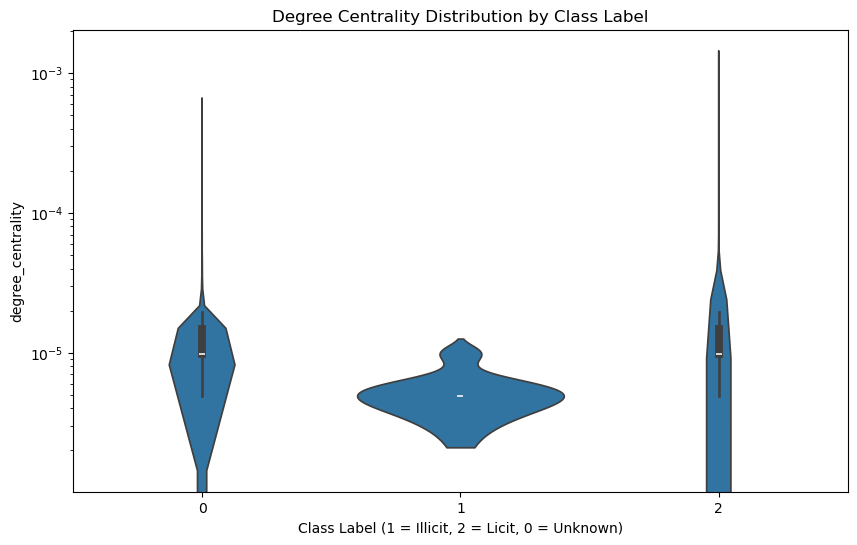

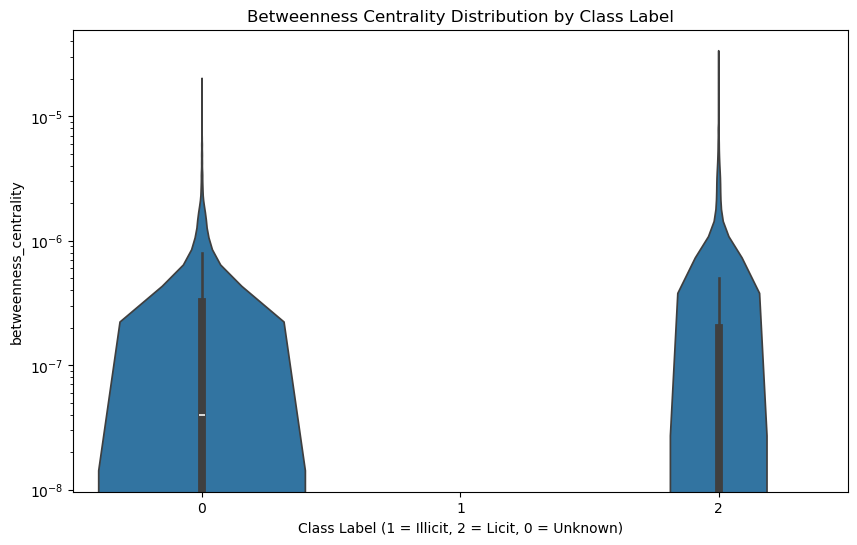

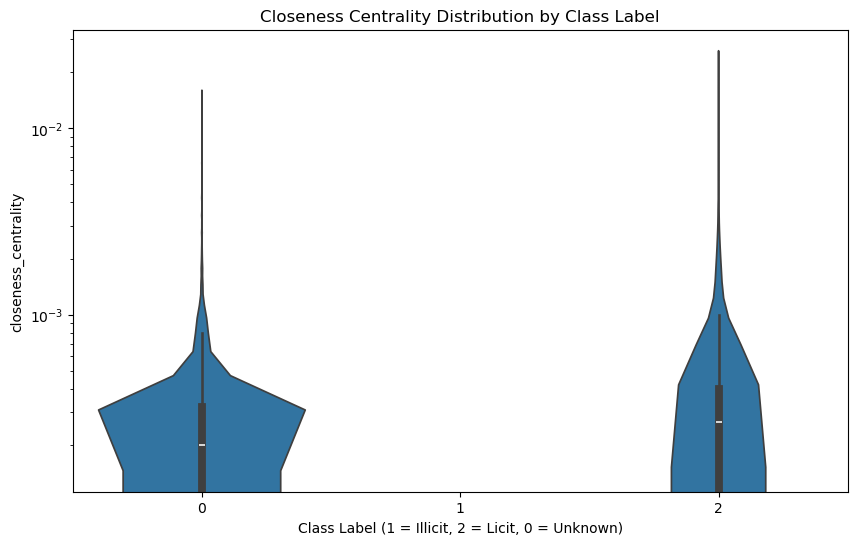

In [116]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_violin(df, metric, title):
    plt.figure(figsize=(10, 6))
    sns.violinplot(x='class_label', y=metric, data=df, inner='box')
    plt.title(title)
    plt.xlabel('Class Label (1 = Illicit, 2 = Licit, 0 = Unknown)')
    plt.ylabel(metric)
    plt.yscale('log')
    plt.show()

# Degree Centrality
plot_violin(df_centrality, 'degree_centrality', 'Degree Centrality Distribution by Class Label')

# Betweenness Centrality
plot_violin(df_centrality, 'betweenness_centrality', 'Betweenness Centrality Distribution by Class Label')

# Closeness Centrality
plot_violin(df_centrality, 'closeness_centrality', 'Closeness Centrality Distribution by Class Label')


| Metric                     | Illicit Nodes              | Licit/Unknown Nodes                |
| -------------------------- | -------------------------- | ---------------------------------- |
| **Degree Centrality**      | Very low (mean ≈ 0.000006) | Higher (mean ≈ 0.000016 for licit) |
| **Betweenness Centrality** | **0 or near zero**         | Small but nonzero values           |
| **Closeness Centrality**   | **0 or near zero**         | Higher than illicit                |


Illicit transactions are structurally peripheral in the network.
They do not act as hubs, connectors, or bridges.

They likely:

Have few connections.

Are terminal nodes (e.g., at the edge of the transaction flow).

Avoid central positions to remain hidden.

### Fraud density vs centrality

C:\Users\User\AppData\Local\Temp\ipykernel_8048\1044162080.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fraud_density = df_filtered.groupby('metric_bin')['class_label'].apply(
C:\Users\User\AppData\Local\Temp\ipykernel_8048\1044162080.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fraud_density['bin_center'] = df_filtered.groupby('metric_bin')[metric].mean().values


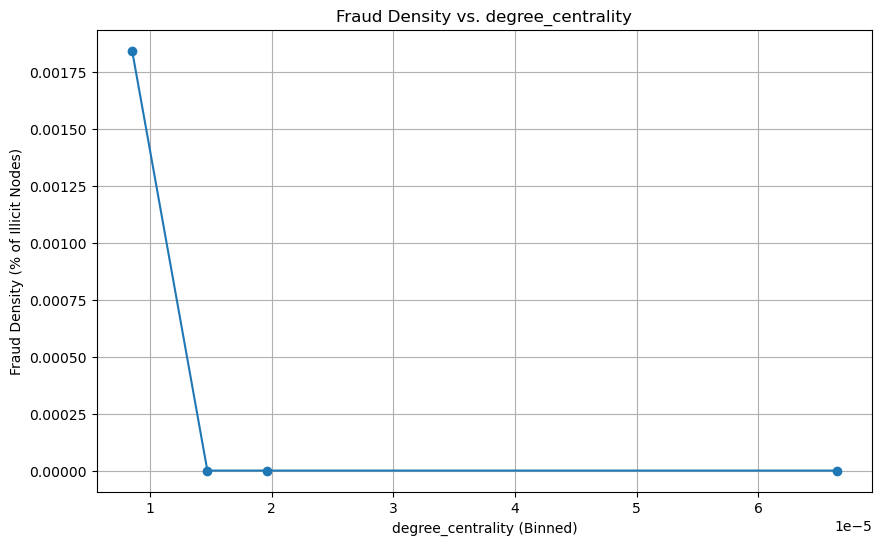

C:\Users\User\AppData\Local\Temp\ipykernel_8048\1044162080.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fraud_density = df_filtered.groupby('metric_bin')['class_label'].apply(
C:\Users\User\AppData\Local\Temp\ipykernel_8048\1044162080.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fraud_density['bin_center'] = df_filtered.groupby('metric_bin')[metric].mean().values


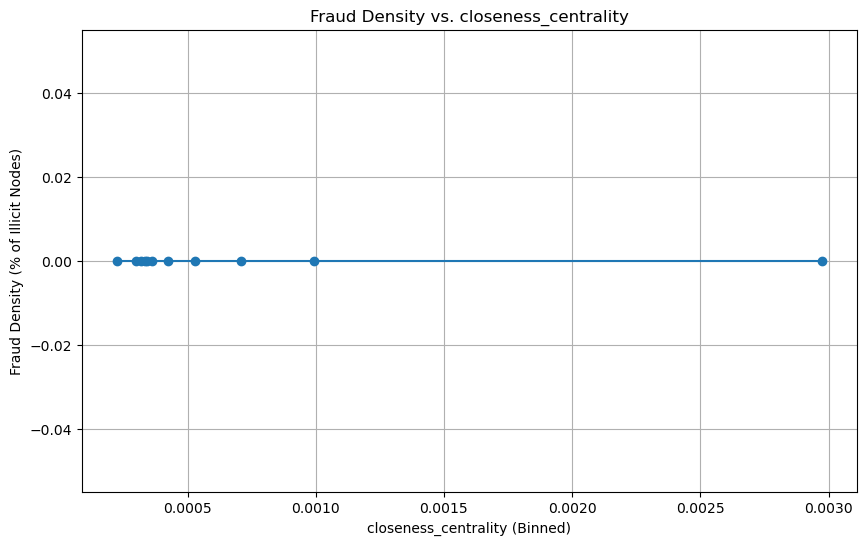

In [ ]:

def plot_fraud_density_vs_metric(df, metric, bins=20):
    """
    Bins nodes by a centrality metric and plots % of illicit nodes per bin.
    """
    # Only use nodes with non-zero metric to avoid skew
    df_filtered = df[df[metric] > 0].copy()

    df_filtered['metric_bin'] = pd.qcut(df_filtered[metric], q=bins, duplicates='drop')

    fraud_density = df_filtered.groupby('metric_bin')['class_label'].apply(
        lambda x: (x == 1).sum() / len(x)
    ).reset_index(name='fraud_density')

    fraud_density['bin_center'] = df_filtered.groupby('metric_bin')[metric].mean().values

    plt.figure(figsize=(10, 6))
    plt.plot(fraud_density['bin_center'], fraud_density['fraud_density'], marker='o')
    plt.xlabel(f'{metric} (Binned)')
    plt.ylabel('Fraud Density (% of Illicit Nodes)')
    plt.title(f'Fraud Density vs. {metric}')
    plt.grid(True)
    plt.show()

# Example with degree_centrality
plot_fraud_density_vs_metric(df_centrality, 'degree_centrality', bins=20)

# Example with closeness_centrality
plot_fraud_density_vs_metric(df_centrality, 'closeness_centrality', bins=20)
